In [126]:
from importlib import reload
import functions
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
reload(functions)

<module 'functions' from 'c:\\Users\\valta\\Documents\\GitHub\\adaml-ml-project\\functions.py'>

In [127]:
data_path = "household_power_consumption.txt"
df = functions.load_data(data_path)
df_hourly = functions.preprocess_data(df).reset_index()
#Add time variables: weekday, hour and day of year. Use sin/cosine transforms
df_hourly["hour_sin"] = np.sin(2*np.pi*(df_hourly["datetime"].dt.hour)/24)
df_hourly["hour_cos"] = np.cos(2*np.pi*(df_hourly["datetime"].dt.hour)/24)

df_hourly["weekday_sin"] = np.sin(2*np.pi*(df_hourly["datetime"].dt.weekday)/7)
df_hourly["weekday_cos"] = np.cos(2*np.pi*(df_hourly["datetime"].dt.weekday)/7)

df_hourly["day_of_year_sin"] = np.sin(2*np.pi*(df_hourly["datetime"].dt.day_of_year)/365)
df_hourly["day_of_year_cos"] = np.cos(2*np.pi*(df_hourly["datetime"].dt.day_of_year)/365)

In [128]:
last_year = len(df_hourly) - 24*365

# Split data into training/validation and test sets, last year for testing
train_val_data = df_hourly.iloc[:last_year,1:].copy()
test_data      = df_hourly.iloc[last_year:,1:].copy()

train_data,val_data = train_test_split(train_val_data,test_size=0.3,shuffle=False)

In [194]:
scaler = MinMaxScaler()
scaler.fit(train_data)  # fit only on train

train_scaled = pd.DataFrame(
    scaler.transform(train_data),
    columns=train_data.columns
)

val_scaled = pd.DataFrame(
    scaler.transform(val_data),
    columns=val_data.columns
)

test_scaled = pd.DataFrame(
    scaler.transform(test_data),
    columns=test_data.columns
)

# index of target column inside scaled arrays
target_index = list(train_data.columns).index("Global_active_power")

In [195]:
class EnergyData24h(Dataset):
    """
    X: [window, n_features]
    y: vector of length 24 (next 24 hours of target_col)
    """
    def __init__(self, data, window, horizon=24, target_col="Global_active_power"):
        data = data.reset_index(drop=True)
        self.window  = window
        self.horizon = horizon

        self.X_all = data.values.astype("float32")  # (N, F)
        self.target_idx = data.columns.get_loc(target_col)
        self.y_all = self.X_all[:, self.target_idx] # (N,)

        N = len(self.X_all)
        # i + window + horizon - 1 < N  -> i <= N - window - horizon
        self.num_samples = max(0, N - window - horizon + 1)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        # history window
        x = self.X_all[index : index + self.window, :]  # (window, F)

        # next 24 hours
        start_y = index + self.window
        end_y   = start_y + self.horizon
        y = self.y_all[start_y:end_y]                   # (horizon,)

        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        return x, y


In [220]:
window  = 72    # history length (previous 24h)
horizon = 24    # forecast length (next 24h)

train_df = train_scaled.copy()
val_df   = val_scaled.copy()
test_df  = test_scaled.copy()

train_dataset = EnergyData24h(train_df, window=window, horizon=horizon)
val_dataset   = EnergyData24h(val_df,   window=window, horizon=horizon)
test_dataset  = EnergyData24h(test_df, window=window, horizon=horizon)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)


In [221]:
# https://www.ibm.com/think/topics/positional-encoding?
# & AI
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x: (B, S, d_model)
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]


In [222]:
# https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html
class TransformerModel(nn.Module):
    def __init__(
        self,
        num_features,
        d_model=128,
        nhead=4,
        num_layers=3,
        dim_feedforward=128,
        max_len=5000,
        horizon=24,
        dropout=0.1,
    ):
        super().__init__()
        self.input_proj = nn.Linear(num_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(d_model, horizon)

    def forward(self, x):
        # x: (B, S, F)
        x = self.input_proj(x)      # (B, S, d_model)
        x = self.pos_encoder(x)     # (B, S, d_model)
        x = self.encoder(x)         # (B, S, d_model)

        # Average over time dimension
        x = x.mean(dim=1)           # (B, d_model)

        out = self.fc_out(x)        # (B, horizon)
        return out

In [223]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_losses = []
val_losses = []
best_val_losses = []
best_val_loss = float("inf")

num_features = train_df.shape[1]
model = TransformerModel(num_features=num_features, horizon=horizon).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)

num_epochs = 20

for epoch in range(1, num_epochs + 1):
    # training 
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)  # (B, window, F)
        y_batch = y_batch.to(device)  # (B, 24)

        optimizer.zero_grad()
        preds = model(X_batch)        # (B, 24)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch:02d} | Train MSE: {train_loss:.4f} | Val MSE: {val_loss:.4f}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    

Epoch 01 | Train MSE: 0.0300 | Val MSE: 0.0148
Epoch 02 | Train MSE: 0.0194 | Val MSE: 0.0135
Epoch 03 | Train MSE: 0.0171 | Val MSE: 0.0113
Epoch 04 | Train MSE: 0.0155 | Val MSE: 0.0108
Epoch 05 | Train MSE: 0.0150 | Val MSE: 0.0105
Epoch 06 | Train MSE: 0.0146 | Val MSE: 0.0105
Epoch 07 | Train MSE: 0.0143 | Val MSE: 0.0103
Epoch 08 | Train MSE: 0.0140 | Val MSE: 0.0103
Epoch 09 | Train MSE: 0.0138 | Val MSE: 0.0103
Epoch 10 | Train MSE: 0.0136 | Val MSE: 0.0098
Epoch 11 | Train MSE: 0.0134 | Val MSE: 0.0100
Epoch 12 | Train MSE: 0.0132 | Val MSE: 0.0095
Epoch 13 | Train MSE: 0.0131 | Val MSE: 0.0103
Epoch 14 | Train MSE: 0.0130 | Val MSE: 0.0101
Epoch 15 | Train MSE: 0.0128 | Val MSE: 0.0096
Epoch 16 | Train MSE: 0.0126 | Val MSE: 0.0094
Epoch 17 | Train MSE: 0.0125 | Val MSE: 0.0097
Epoch 18 | Train MSE: 0.0125 | Val MSE: 0.0096
Epoch 19 | Train MSE: 0.0123 | Val MSE: 0.0096
Epoch 20 | Train MSE: 0.0122 | Val MSE: 0.0093


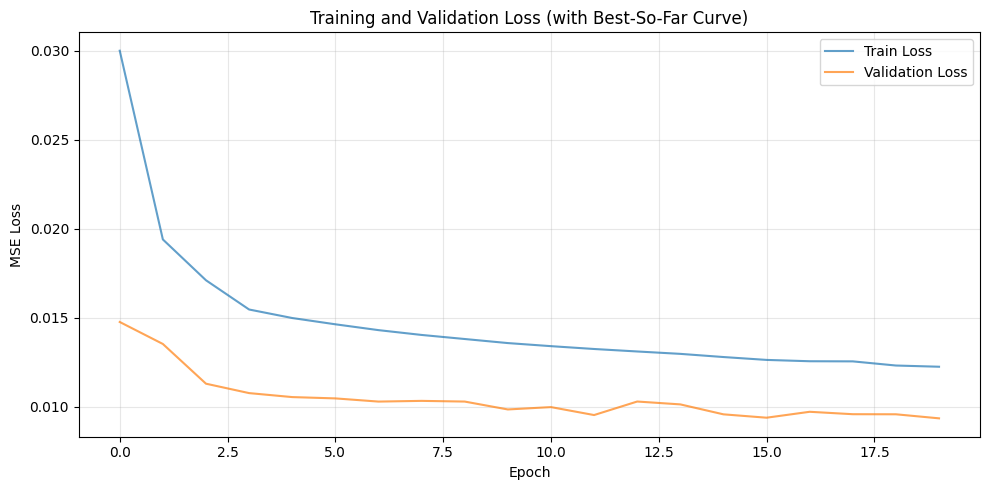

In [224]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss", alpha=0.7)
plt.plot(val_losses, label="Validation Loss", alpha=0.7)

plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss (with Best-So-Far Curve)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [225]:
model.eval()
test_loss = 0.0
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        preds = model(X_batch)

        loss = criterion(preds, y_batch)
        test_loss += loss.item() * X_batch.size(0)

        y_true_list.append(y_batch.cpu())
        y_pred_list.append(preds.cpu())

test_loss /= len(test_loader.dataset)
print(f"Test MSE (24h vector): {test_loss:.4f}")

# Stack all test predictions
y_true = torch.cat(y_true_list, dim=0).numpy()  # (N_samples, 24)
y_pred = torch.cat(y_pred_list, dim=0).numpy()  # (N_samples, 24)




Test MSE (24h vector): 0.0098


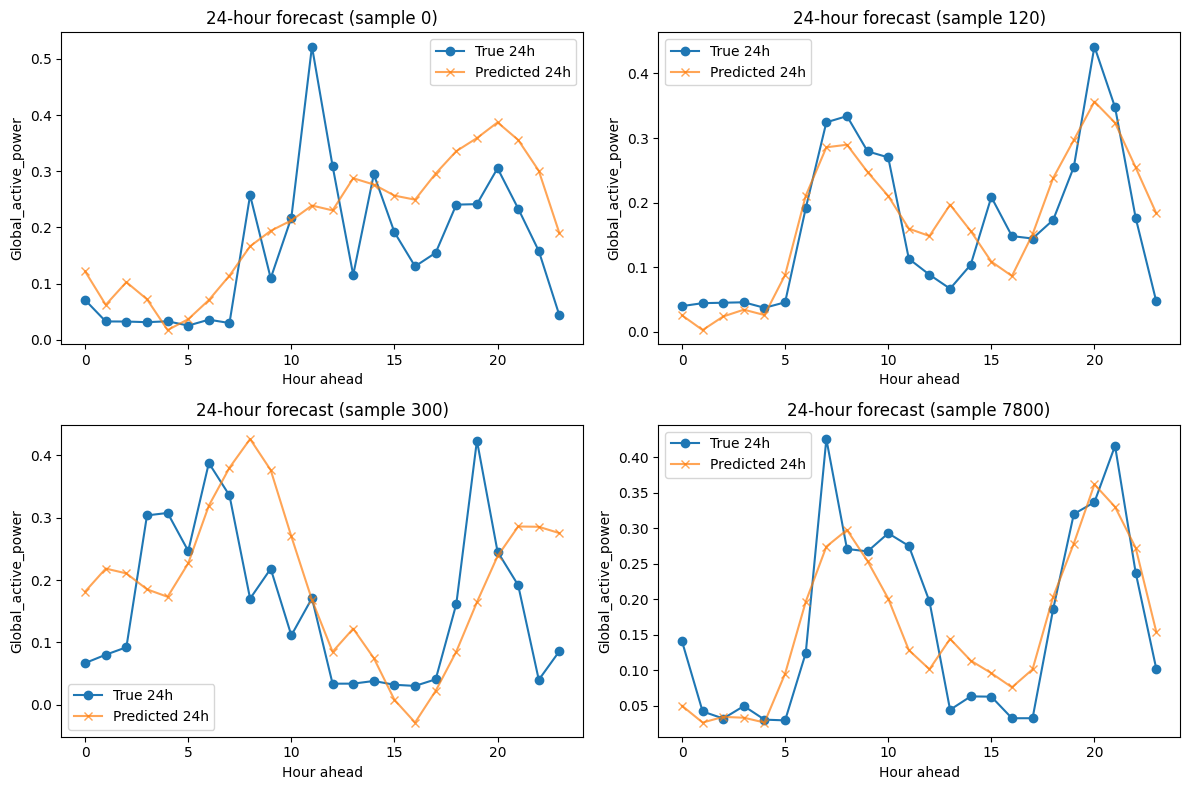

In [247]:
sample_indices = [0, 120, 300, 7800]

plt.figure(figsize=(12, 8))

for i, idx in enumerate(sample_indices):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_true[idx], label="True 24h", marker="o")
    plt.plot(y_pred[idx], label="Predicted 24h", marker="x", alpha=0.7)
    plt.xlabel("Hour ahead")
    plt.ylabel("Global_active_power")
    plt.title(f"24-hour forecast (sample {idx})")
    plt.legend()

plt.tight_layout()
plt.show()
